In [186]:
#BASIC MODULES
import re
import os
import string
import numpy as np
import pandas as pd
import seaborn as sn
from numpy import array
import matplotlib.pyplot as plt

#MODULE FOR STRATIFIED K-FOLD CROSS-VALIDATION
from sklearn.model_selection import StratifiedKFold

#KERAS MODULES FOR NN MODELS
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from nltk.stem import WordNetLemmatizer

#MODULES FOR DISPLAY PURPOSES
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', 100000000)
pd.set_option('display.max_info_columns', 100000000)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

#HIDE REPEATING WARNING
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [187]:
#IMPORT DATA AND DROP DUPLICATES
df = pd.read_excel('train.xlsx')
df = df.drop_duplicates('Sentence')

#NUMERIZE SENTIMENT
polarity = {'positive': 1,'negative': 0} 
df['Sentiment'] = [polarity[item] for item in df.Sentiment] 

#BALANCE SENTIMENT
pos = df[df.Sentiment==1].sample(n = len(df[df.Sentiment==0]))
neg = df[df.Sentiment==0]
df = pos.append(neg)
df.Sentiment.value_counts()

1    1683
0    1683
Name: Sentiment, dtype: int64

In [188]:
#NORMALIZE TEXT DATA

#SHUFFLE
df = df.sample(frac=1).reset_index(drop=True)

#LOWER CASE
df['Sentence2'] = [x.lower() for x in df.Sentence]

#CONTRACTIONS
def decontracted(phrase):
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
df['Sentence2'] = [decontracted(x) for x in df['Sentence2']]


#REMOVE PUNCTUATION
df['Sentence2'] = df['Sentence2'].str.replace("[^a-zA-Z#]", " ")
df['Sentence2'] = [x.replace("\\n",'') for x in df.Sentence2]

#TOKENIZE - FOR NLTK
df['Sentence2'] = [x.split() for x in df.Sentence2]

#LEMENZIE - NLTK
wordnet_lemmatizer = WordNetLemmatizer()
def lem(words):
    return [wordnet_lemmatizer.lemmatize(word,pos="v") for word in words]
df['Sentence2'] = [lem(x) for x in df['Sentence2']]
df['Sentence2'] = [" ".join(x) for x in df.Sentence2]

#FIND NUMBER OF WORDS IN EACH ENTRY
df['length'] = [len(x.split()) for x in df.Sentence2]
df = df[['Sentence','Sentence2','length','Sentiment']]
df.head(2)

,Sentence,Sentence2,length,Sentiment
0,quick and efficient service provided but in common with most companies was forced to pay for a courtesy car which was not required.,quick and efficient service provide but in common with most company be force to pay for a courtesy car which be not require,23,0
1,After a quick query by telephone we arranged insurance for our new home online with ease.,after a quick query by telephone we arrange insurance for our new home online with ease,16,1


In [189]:
#FIND NUMBER OF UNIQUE WORDS
allwords = df.Sentence2.values.tolist()
vocab_size = len(list(set(" ".join(allwords).split())))
vocab_size

3397

In [190]:
#GET FROM DATAFRAME
X = df['Sentence2'].values.tolist()
y = df['Sentiment'].values

#CONVERT WORDS TO NUMBERS
X_encoded = [one_hot(d, vocab_size) for d in X]

#PADDING OUT ARRAYS TO LENGTH OF LONGEST ARRAY
max_length = df['length'].max()+10 # plus 10 TO ACCOUNT FOR EXTRA WORDS DURING TESTING
X_padded = pad_sequences(X_encoded, maxlen=max_length, padding='post')

In [191]:
#DISPLAY VARIOUS STAGES OF DATA TRANSFORMATION
print(X[1],"\n")
print(X_encoded[1],"\n")
print(X_padded[1])

after a quick query by telephone we arrange insurance for our new home online with ease 

[1370, 2010, 1316, 3168, 329, 193, 438, 297, 19, 1982, 1837, 2948, 175, 3277, 3089, 160] 

[1370 2010 1316 3168  329  193  438  297   19 1982 1837 2948  175 3277
 3089  160    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


In [193]:
#K-FOLDS SPLITTING
kf = StratifiedKFold(5, shuffle=True, random_state=42)
scores = pd.DataFrame(columns = ['Dimensions','Epochs','Fold','Val_Acc','Val_Loss'])
val_acc_scores = []
val_loss_scores = []
fold = 0
for train, val in kf.split(X_padded,df['Sentiment']):
    fold+=1
    print(f"Fold #{fold}")
    X_train = X_padded[train]
    y_train = y[train]
    X_val = X_padded[val]
    y_val = y[val]
    
    #BEST RRSULTS = 80
    dims = [10,20,40,80,160,320]
    for dim in dims:
        #BUILD NN
        model = Sequential()
        model.add(Embedding(vocab_size, dim, input_length=max_length))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        #EARLY STOPPING
        Callbacks = EarlyStopping(monitor='val_loss', 
                                                  min_delta=0.00001, 
                                                  patience=5, 
                                                  verbose=0, 
                                                  mode='auto')
        
        #COMPILE NN
        model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        
        #RUN MODEL AND RECORD METRICS    
        history = model.fit(X_train, y_train,
                        batch_size=1,
                        epochs=999,
                        callbacks = [Callbacks],
                        validation_data=(X_val, y_val),verbose=1)
        
        dictionary = {'Dimensions':dim, 'Epochs':len(history.history['val_accuracy']),'Fold':fold, 'Val_Acc':history.history['val_accuracy'][0],'Val_Loss':history.history['val_loss'][0]}
        scores = scores.append(dictionary, ignore_index=True)
        print()

Fold #1
Train on 2692 samples, validate on 674 samples
Epoch 1/999
2692/2692 [==============================] - 3s 1ms/step - loss: 0.5546 - accuracy: 0.7296 - val_loss: 0.4252 - val_accuracy: 0.7982
Epoch 2/999
2692/2692 [==============================] - 3s 1ms/step - loss: 0.3643 - accuracy: 0.8451 - val_loss: 0.4086 - val_accuracy: 0.8338
Epoch 3/999
2692/2692 [==============================] - 3s 1ms/step - loss: 0.3428 - accuracy: 0.8670 - val_loss: 0.4073 - val_accuracy: 0.8501
Epoch 4/999
2692/2692 [==============================] - 3s 1ms/step - loss: 0.3290 - accuracy: 0.8756 - val_loss: 0.4124 - val_accuracy: 0.8457
Epoch 5/999
2692/2692 [==============================] - 3s 1ms/step - loss: 0.3189 - accuracy: 0.8908 - val_loss: 0.4033 - val_accuracy: 0.8665
Epoch 6/999
2692/2692 [==============================] - 3s 1ms/step - loss: 0.3103 - accuracy: 0.8930 - val_loss: 0.4250 - val_accuracy: 0.8739
Epoch 7/999
2692/2692 [==============================] - 3s 1ms/step - loss

In [194]:
#COLLATING RESULTS
averages = pd.DataFrame(columns=['Dimension','Epoch Avg','Val_Acc Avg','Val_Loss Avg'])
for dim in dims:
    results = scores[scores.Dimensions==dim]
    display(results)
    results.pop('Fold')
    results.pop('Dimensions')
    dictionary = {'Dimension':dim,'Epoch Avg':results.Epochs.describe()[1],'Val_Acc Avg':results.Val_Acc.describe()[1],'Val_Loss Avg':results.Val_Loss.describe()[1]}
    averages = averages.append(dictionary, ignore_index=True)
averages

,Dimensions,Epochs,Fold,Val_Acc,Val_Loss
0,10.0,10.0,1.0,0.798220,0.425162
1,10.0,8.0,2.0,0.827893,0.398963
2,10.0,7.0,3.0,0.823442,0.392389
3,10.0,8.0,4.0,0.819940,0.429402
4,10.0,7.0,5.0,0.802083,0.430218


,Dimension,Epoch Avg,Val_Acc Avg,Val_Loss Avg
0,10.0,8.0,0.814316,0.415227


In [195]:
#CREATE PIPLINE TO TEST MODEL ON INPUT SENTENCES:
def predict(x):
    x = x.lower()
    x = decontracted(x)
    x = re.sub(r'[^\w\s]','',x)
    x = "".join(lem(x))
    x = one_hot(x, vocab_size)
    while len(x)<max_length:
        x.append(0)
    x = np.array(x)
    x = x.reshape(1,-1)
    return int(round(model.predict(x)[0][0],0))

In [196]:
#EXAMPLE
print(predict('good customer service'))
print(predict('bad customer service'))

1
0


In [197]:
#RUNNING MODEL ON UNLABELED TEST DATASET
test_df = pd.read_excel('test.xlsx')
test_df['Prediction'] = [predict(x) for x in test_df['Sentence']]
test_df.sample(n=5)

,Sentence,Entity,Prediction
1062,"well i've never had any problem with then, but that's not to say others wouldn't !",problem,0
915,"good service, but i have never made a claim.",claim,0
812,i have to go elsewhere to get a better deal.,deal,0
986,never had a problem with them neither with premium or claim.,problem,0
1148,"they could have provided a competitive renewal price in the first place, this would have avoided me searching round to find a better price which axa then matched.",renewal price,1


Precision:  0.89
Recall:  0.88
f1:  0.44


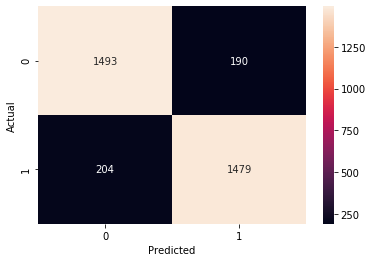

In [198]:
#RUNNING MODEL ON TRAINING SET TO COMPARE PREDICTIONS WITH GROUND TRUTHS
df['Prediction'] = [predict(x) for x in df.Sentence]
confusion_matrix = pd.crosstab(df['Sentiment'], df['Prediction'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True,fmt='g')
true_pos = confusion_matrix[1][1]
true_neg = confusion_matrix[0][0]
false_pos = confusion_matrix[1][0]
false_neg = confusion_matrix[0][1]

precision = (true_pos)/(true_pos+false_pos)
recall = (true_pos)/(true_pos+false_neg)
f1 = (precision*recall)/(precision+recall)

print('Precision: ',round(precision,2))
print('Recall: ',round(recall,2))
print('f1: ',round(f1,2))

In [199]:
#ANALYSING WHERE THE MODEL PREDICTED INCORRECTLY
def result(x,y):
    if x==0 and y ==0:
        return "TN"
    if x==0 and y==1:
        return 'FP'
    if x==1 and y ==1:
        return "TP"
    if x==1 and y==0:
        return 'FN'
    
df['Result'] = [result(x,y) for x,y in zip(df.Sentiment,df.Prediction)]
df =df[['Sentence','Sentiment','Prediction','Result']]
df[(df.Result=='FP') | (df.Result=='FN')].sample(n=5)

,Sentence,Sentiment,Prediction,Result
3258,Paying was easy call operater was excellent but a rather noisy background.,0,1,FP
3139,all great except the wording on whether you were happy to receive further contact i. e. marketing via email text etc was purposely confusing i did not want to receive further contact and had to read the question several times because of the way it was worded but i can see i've ticked the wrong boxes because it was not clear and i am already receiving emails so i will now have to phone to have this removed.,0,1,FP
367,Great value and made some savings compared to my previous insurer.,0,1,FP
2944,I used a comparison site but still chose AXA as a good policy.,1,0,FN
142,With regards to improvements please don't assume that everybody owns a computer although the representative informed me that a hard copy would be sent via the postal system another positive experience - congratulations.,1,0,FN
